In [1]:
import pandas as pd
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Black Orchestra

Black Orchestra is a board game with dice mechanics that are hard to estimate intuitively. I made this tool to help make decisions in-game. 

In [2]:
DICE = [1,2,3,'cross','eagle']
def evaluate_roll(die_cnt):
    roll = []
    for _ in range(die_cnt):
        random.shuffle(DICE)
        roll.append(DICE[0])
    ones = sum([1 for face in roll if face is 1])
    twos = sum([1 for face in roll if face is 2])
    threes = sum([1 for face in roll if face is 3])
    turns = sum([1 for face in roll if type(face) is int])
    crosses = sum([1 for face in roll if face is 'cross'])
    eagles = sum([1 for face in roll if face is 'eagle'])
    return({'ones':ones,'twos':twos,'threes':threes,
            'turns':turns, 'crosses':crosses,'eagles':eagles})
def repeat_trial(die_cnt,n):
    sample = []
    for _ in range(n):
        sample.append(evaluate_roll(die_cnt))
    return(pd.DataFrame(sample))
def determine_detection(df,suspicion):
    df['detected'] = df['eagles'] >= suspicion
    return(df)
def determine_success(df,military_support):
    df['success'] = df['crosses']  >= military_support
    return(df)
def determine_harmless_fail(df):
    df['harmless_fail'] = ~df['success'] & (df['success'] == df['detected'])
    return(df)
    
INPUT = {'die_cnt':10, 'n':30, 'suspicion':2, 'military_support':3}
def summarize_results(die_cnt, n, suspicion, military_support):
    df = repeat_trial(die_cnt=die_cnt,n=n)
    determine_detection(df, suspicion=suspicion)
    determine_success(df, military_support=military_support)
    determine_harmless_fail(df)
    summary = {'die_cnt':die_cnt,
               'n':n,
               'suspicion':suspicion,
               'military_support':military_support}
    summary['ones'] = mean(df['ones'])
    summary['twos'] = mean(df['twos'])
    summary['threes'] = mean(df['threes'])
    summary['turns'] = mean(df['turns'])
    summary['detected_cnt'] = sum(df['detected'])
    summary['success_cnt'] = sum(df['success'])
    summary['harmless_fail_cnt'] = sum(df['harmless_fail'])
    summary['fail_and_detected'] = round(100*(sum(df['detected'])/n))
    summary['fail'] = round(100*(sum(df['harmless_fail'])/n))
    summary['succeed'] = round(100*(sum(df['success'])/n))
    return(summary)
summarize_results(**INPUT)

{'die_cnt': 10,
 'n': 30,
 'suspicion': 2,
 'military_support': 3,
 'ones': 1.6666666666666667,
 'twos': 2.1,
 'threes': 1.9333333333333333,
 'turns': 5.7,
 'detected_cnt': 20,
 'success_cnt': 10,
 'harmless_fail_cnt': 5,
 'fail_and_detected': 67.0,
 'fail': 17.0,
 'succeed': 33.0}

In [3]:
repeat_trial(die_cnt=10,n=5)

,ones,twos,threes,turns,crosses,eagles
0,1,2,1,4,4.0,2
1,1,2,3,6,2.0,2
2,2,1,1,4,3.0,3
3,2,4,2,8,1.0,1
4,1,3,3,7,0.0,3


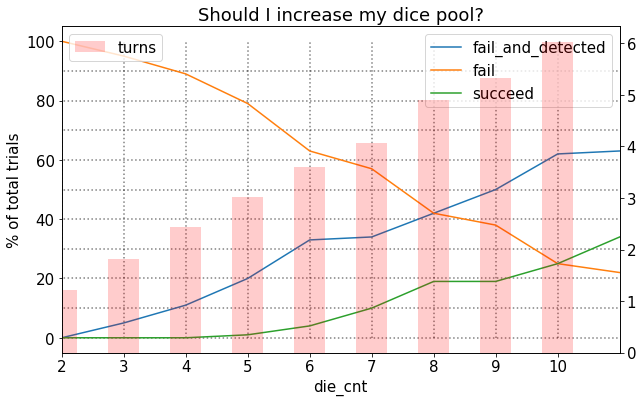

In [4]:
def adjust_die(n, suspicion, military_support,die_in_box=10, **kwargs):
    results_per_die_cnt = []
    for die_this_roll in range(1,die_in_box+1):
        results_per_die_cnt.append(summarize_results(die_this_roll,n,suspicion,military_support))
    df = pd.DataFrame(results_per_die_cnt)
    return(df.set_index('die_cnt'))
def consider_increasing_dice(df):
    font = {'size'   : 15}
    matplotlib.rc('font', **font)
    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    df[['turns']].plot(kind='bar',ax=ax2,color='r', alpha = 0.2)
    df[['fail_and_detected','fail','succeed']].plot(ax=ax1)
    ax1.set_title('Should I increase my dice pool?')
    ax1.set_ylabel('% of total trials')
    ax1.vlines(range(10),0,100,linestyles='dotted',alpha=0.5)
    ax1.hlines(range(0,100,10),0,10,linestyles='dotted', alpha=0.5)
    
    
INPUT = {'n':300, 'suspicion':2, 'military_support':3}
consider_increasing_dice(adjust_die(**INPUT))

In [5]:
INPUT = {'n':300, 'suspicion':2, 'military_support':3}
df =adjust_die(**INPUT)

In [6]:

SUSPICION_MAP = {'low':3, 'medium':2, 'high':1, 'extreme':1}
MILITARY_MAP = list(range(2,7+1))

def compute_susmil(n=300, **kwargs):
    wallclock = -time.time()
    # Init the dataframe
    this_input = {'n':n, 'suspicion':SUSPICION_MAP['low'], 'military_support':2}
    tmp = adjust_die(**this_input).reset_index()
    # for a given num dice, how does sus/mil effect success/failure?
    cnt = 0
    for sus in SUSPICION_MAP:
        for mil_val in MILITARY_MAP:
            # Skip initial.
            if sus=='low' and mil_val==2:
                continue
            this_input = {'n':300, 'suspicion':SUSPICION_MAP[sus], 'military_support':mil_val}
            tmp = tmp.append(adjust_die(**this_input).reset_index())
            cnt = cnt +1
    df = tmp.reset_index(drop=True)
    print('Iterations (compute_susmil):',cnt+1)
    print('Trials (compute_susmil):',(cnt+1)*n)
    print('Compute time (compute_susmil):',wallclock+time.time())
    return(df)
df = compute_susmil(n=300)

Iterations (compute_susmil): 24
Trials (compute_susmil): 7200
Compute time (compute_susmil): 8.565595865249634


Compute time (get_map_grid): 2.523402690887451


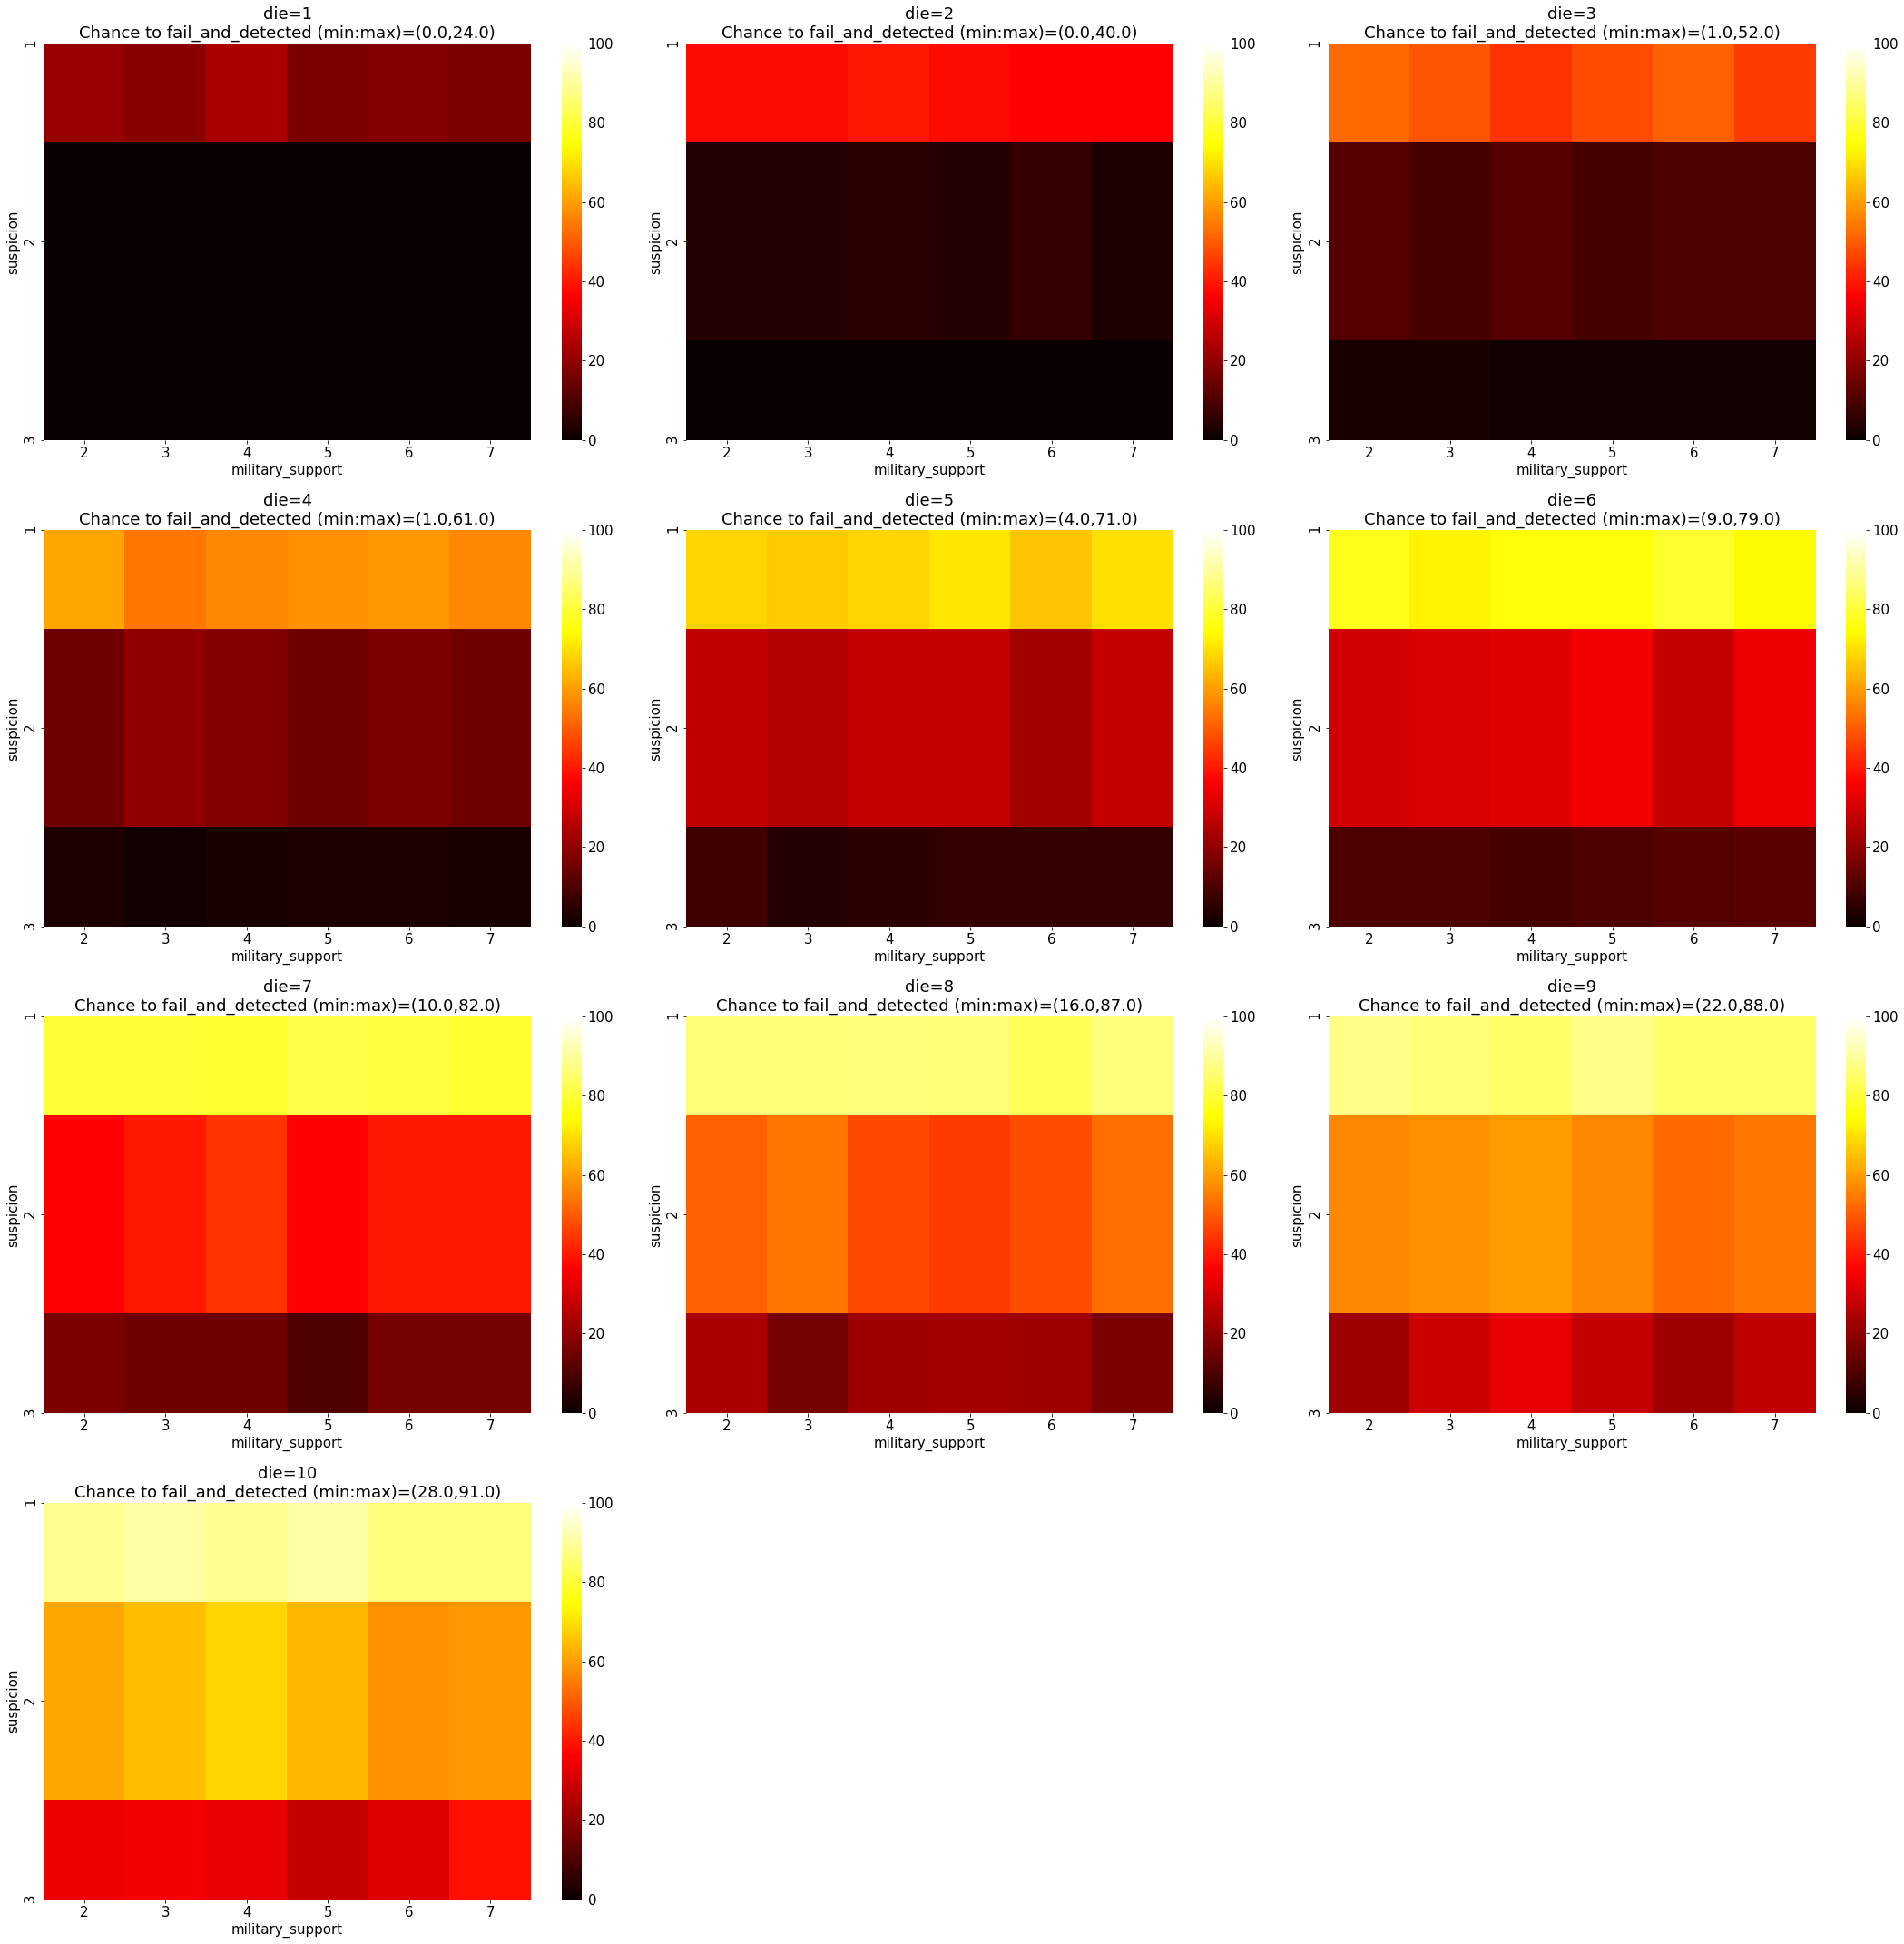

In [7]:
def get_map(df, ax, die_cnt, value, relative=False, **kwargs):
    tmp = df[df['die_cnt']==die_cnt]
    tmp = tmp.drop_duplicates(['suspicion','military_support'])
    tmp = tmp.pivot(index='suspicion',columns='military_support',values=value)
    if relative:
        sns.heatmap(tmp,cmap='hot',ax=ax)
    else:
        sns.heatmap(tmp,cmap='hot',ax=ax,vmin=0,vmax=100)
    ax.set_title('die={}\nChance to {} (min:max)=({},{})'.format(die_cnt, value,
                                                                np.amin(tmp.values),np.amax(tmp.values)))
    return(ax)

# Interesting outcomes: 'succeed', 'fail_and_detected','fail'
def get_map_grid(df, outcome='succeed', relative=False, **kwargs):
    wallclock = -time.time()
    font = {'size'   : 15}
    matplotlib.rc('font', **font)
    fig = plt.figure(figsize=(30,30))
    for die_cnt in range(1,10+1):
        ax = fig.add_subplot(4,3,die_cnt)
        get_map(df, ax,die_cnt=die_cnt,value=outcome,relative=relative)
    plt.tight_layout()
    print('Compute time (get_map_grid):',wallclock+time.time())
    
get_map_grid(df,outcome='fail_and_detected',relative=False)

In [8]:
def consider_susmil(df,n,outcome, relative, **kwargs):
    df = compute_susmil(n)
    get_map_grid(df,outcome,relative)

# tldr;

Just run the preceeding cells, then in the cell below, change the INPUT dict and run.

Iterations (compute_susmil): 24
Trials (compute_susmil): 7200
Compute time (compute_susmil): 8.462967872619629
Compute time (get_map_grid): 2.4356088638305664
TOTAL RUNTIME: 11.397217750549316


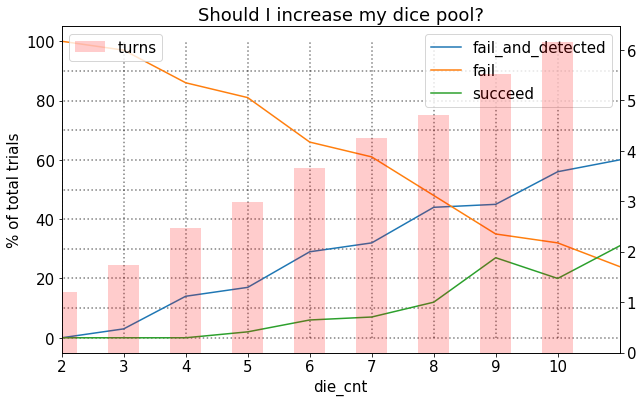

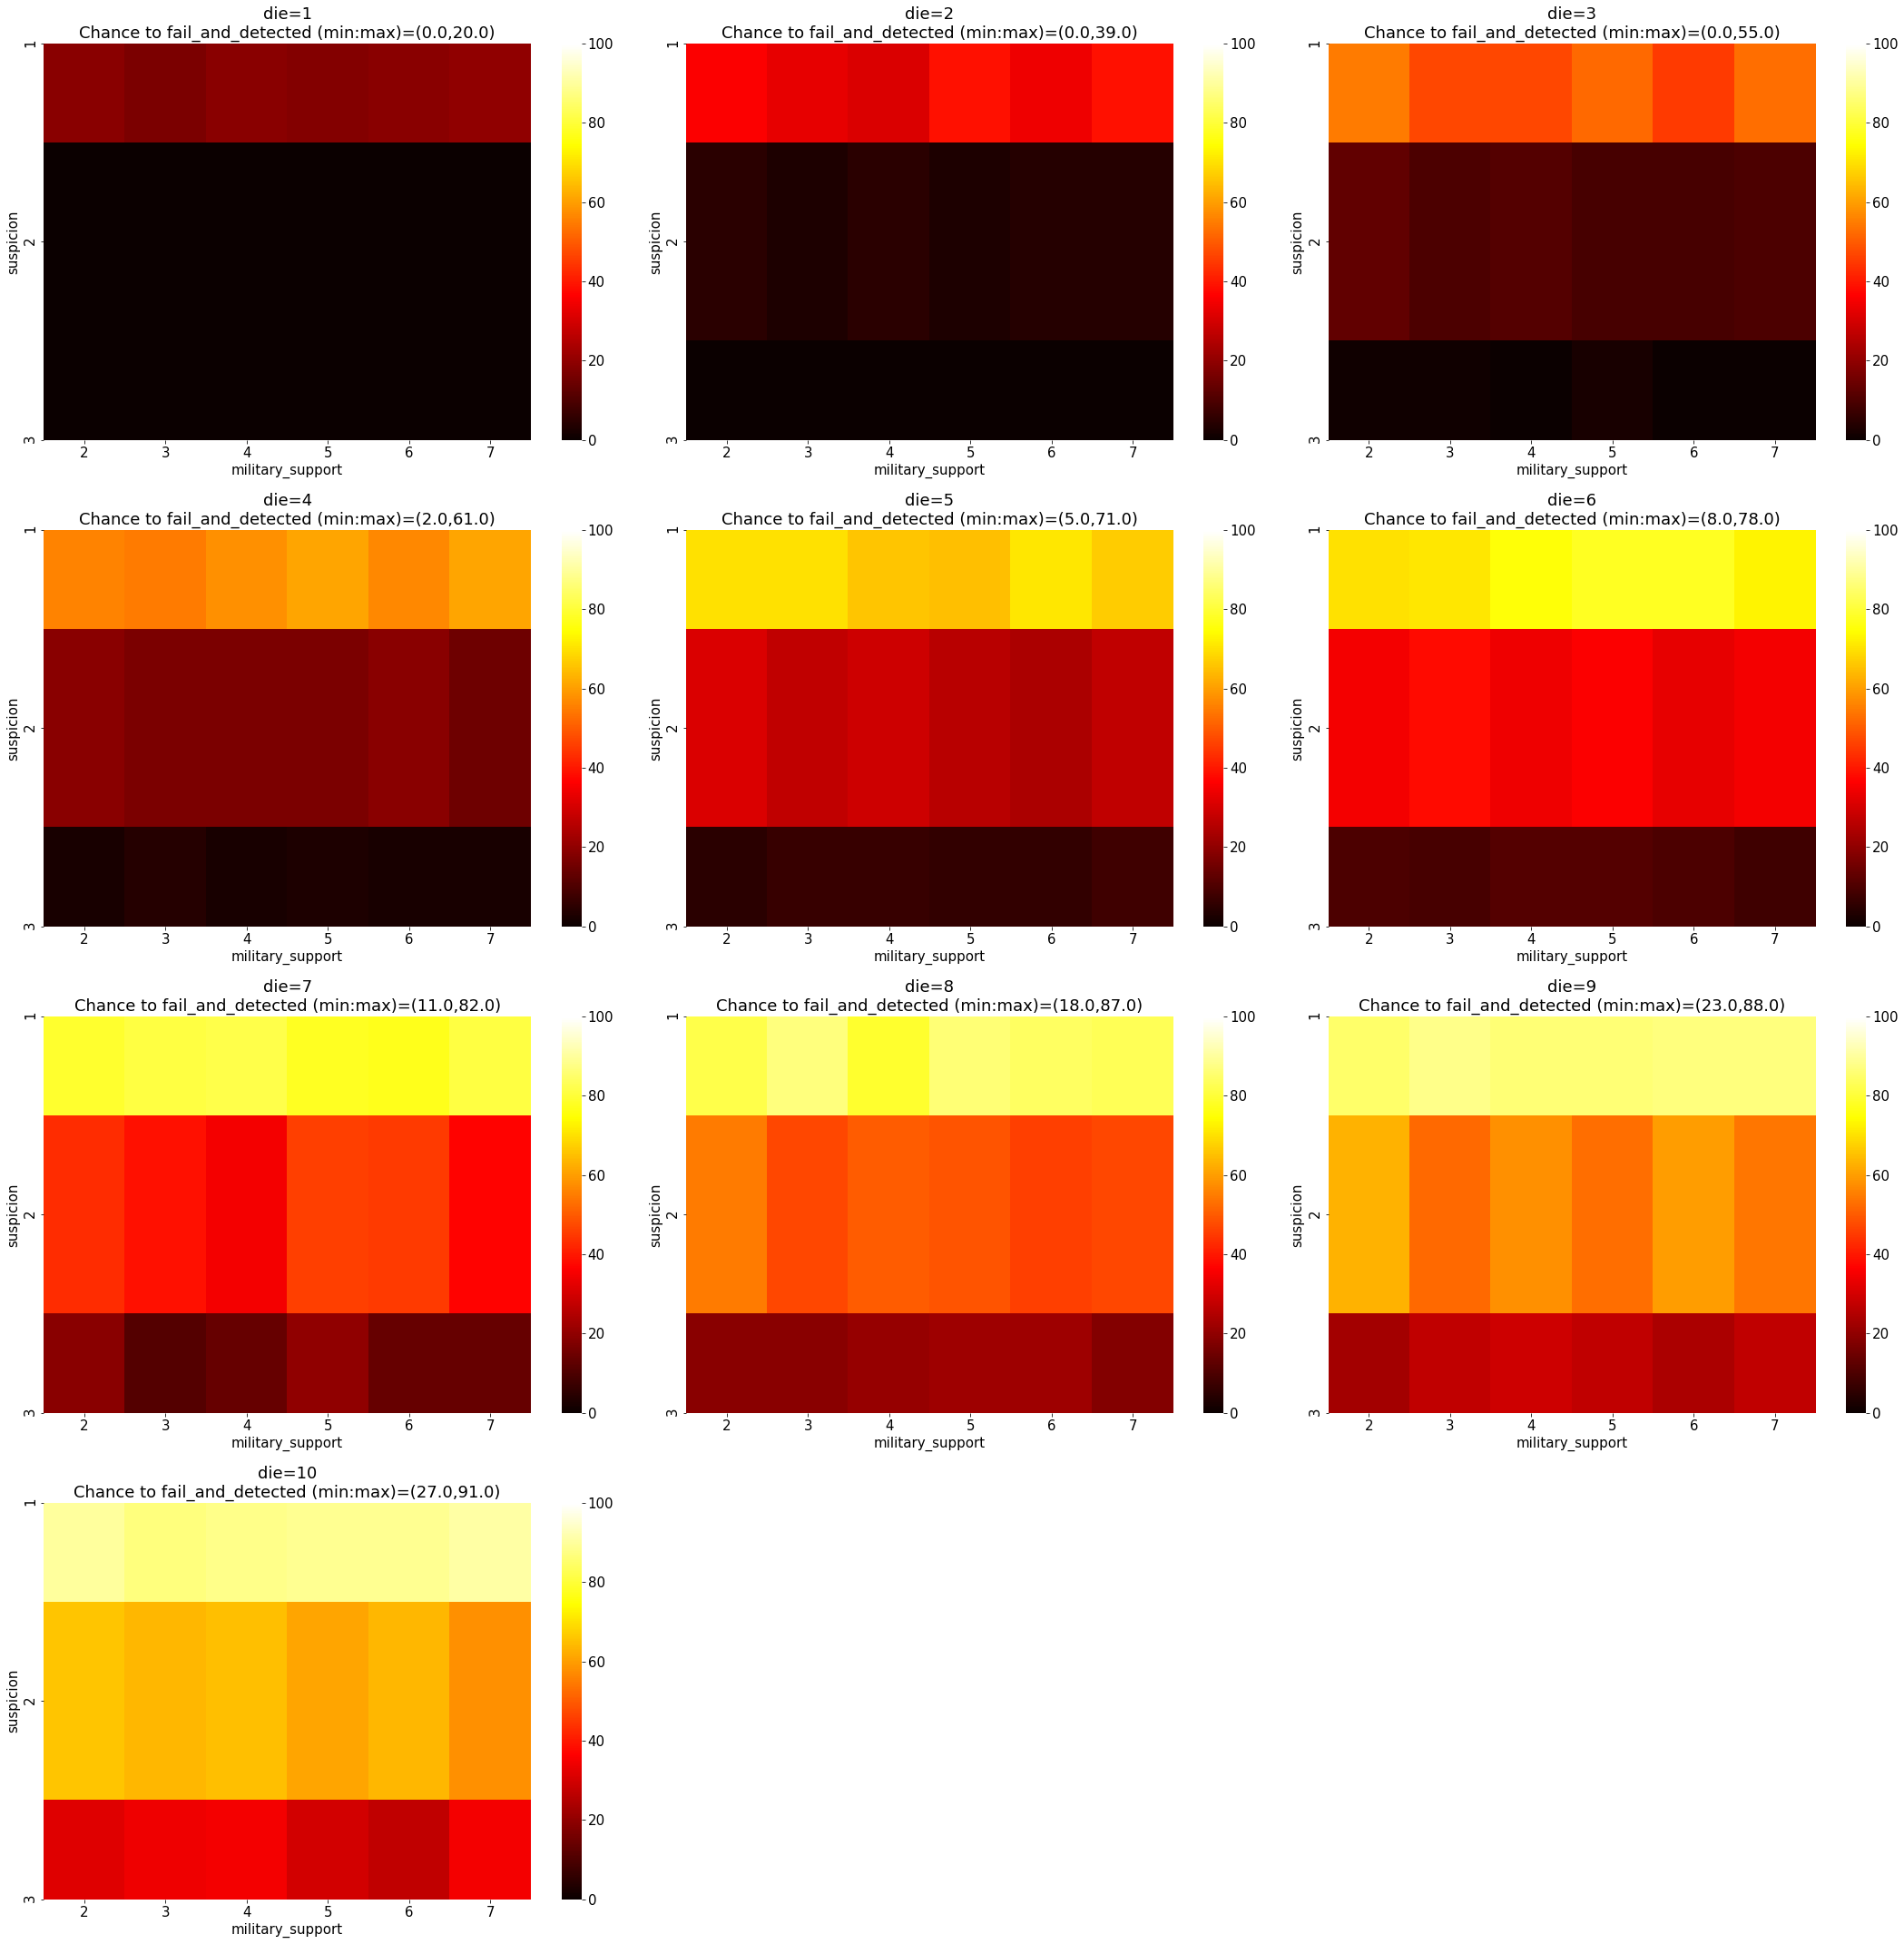

In [9]:
wallclock = -time.time()
INPUT = {'n':300, 'suspicion':2, 'military_support':3,
         'outcome':'fail_and_detected','relative':False}

df = adjust_die(**INPUT)
consider_increasing_dice(df)
consider_susmil(df=df, **INPUT)
print("TOTAL RUNTIME:",wallclock+time.time())